# 🔬 Beijing Air Quality
## 📘 Notebook 05 – Hypothesis H1: Seasonal Patterns in PM2.5

| Field         | Description                                        |
|:--------------|:---------------------------------------------------|
| Author:       |	Robert Steven Elliott                            |
| Course:       |	Code Institute – Data Analytics with AI Bootcamp |
| Project Type: |	Capstone                                         |
| Date:         |	December 2025                                    |

This project complies with the CC BY 4.0 licence by including proper attribution.


## Objectives
- Validate H1: PM2.5 levels show a strong seasonal pattern.
- Analyse monthly and seasonal trends using engineered time features.
- Compare year-on-year seasonal behaviour.
- Investigate the role of weather variables in seasonal PM2.5 changes.

## Inputs
- Feature-engineered dataset containing:
    - PM2.5, month, season, year
    - Weather variables: TEMP, PRES, DEWP, RAIN
    - Engineered features: temp_pres_interaction, dewpoint_spread (if created)

## Outputs
- Monthly and seasonal visualisations
- Year-on-year seasonality comparison
- Weather–PM2.5 seasonal relationship plots
- ANOVA or statistical validation
- Conclusion on whether H1 is supported

## Citation  
This project uses data from:

Chen, Song (2017). *Beijing Multi-Site Air Quality.*  
UCI Machine Learning Repository — Licensed under **CC BY 4.0**.  
DOI: https://doi.org/10.24432/C5RK5G  
Kaggle mirror by Manu Siddhartha.

---

## Hypothesis Introduction

This notebook investigates **Hypothesis H1**, which proposes that PM2.5 concentrations in Beijing follow a strong and recurring seasonal pattern.  
Seasonality is a well-documented characteristic of air quality in East Asian cities, driven by winter heating demand, atmospheric stability, and the East Asian monsoon cycle.

To formally evaluate this hypothesis, we define:

$$
\begin{aligned}
H_0 &: \text{There is no significant difference in mean PM2.5 levels between seasons.} \\
H_1 &: \text{Mean PM2.5 levels differ significantly between seasons.}
\end{aligned}
$$

### Purpose of This Notebook

This notebook examines whether PM2.5 exhibits meaningful seasonal variation by:

- analysing monthly and seasonal patterns,  
- assessing whether seasonal behaviour is consistent year-on-year,  
- exploring how temperature, pressure, and dewpoint relate to PM2.5,  
- performing statistical tests (ANOVA + Tukey HSD) to determine significance.

Through descriptive statistics, visual exploration, and inferential testing, we evaluate whether **H1 is supported** and whether seasonality plays a major role in PM2.5 behaviour.

With the hypothesis defined, we now begin by exploring basic descriptive statistics and seasonal patterns within the feature-engineered dataset.


## Notebook Setup

### Import Required Libraries

(The following libraries support analysis, plotting, and data manipulation.)

In [5]:
import sys # system-level operations
import pandas as pd # data manipulation
import numpy as np # numerical operations
import matplotlib.pyplot as plt # plotting
import seaborn as sns # statistical data visualization
import plotly.express as px # interactive plotting

import pingouin as pg # statistical analysis
from statsmodels.tsa.seasonal import seasonal_decompose # time series decomposition
from pathlib import Path # filesystem paths
import warnings # warning control
warnings.filterwarnings("ignore") # ignore warnings for cleaner output

setup matplotlib and seaborn themes

In [6]:

plt.style.use("seaborn-v0_8") # set matplotlib style
sns.set_theme() # set seaborn theme

### Set Up Project Paths

We define paths for input datasets to ensure the notebook is portable and reproducible.

In [7]:
PROJECT_PATH = Path.cwd().parent # Assuming this script is in a subdirectory of the project root
DATA_PATH = PROJECT_PATH / "data" # Path to the data directory

sys.path.append(str(PROJECT_PATH)) # Add project root to sys.path

INPUT_PATH = DATA_PATH / "engineered" / "beijing_engineered.csv" # input file path
FIGURES_PATH = PROJECT_PATH / "figures" / "h1" # path to save figures
FIGURES_PATH.mkdir(parents=True, exist_ok=True) # create figure directory if it doesn't exist
print("Input path :", INPUT_PATH) # Print input path

Input path : /home/robert/Projects/beijing-air-quality/data/engineered/beijing_engineered.csv


### Load Dataset

Load the feature engineered dataset created in Notebook 04.

In [8]:
from utils.load_csv import load_csv # custom data loading function

df = load_csv(INPUT_PATH) # Load cleaned data
df.head() # Display first few rows of the dataframe

,datetime,year,month,day,hour,pm25,temperature,pressure,dew_point,rain,...,season,day_of_week,hour_sin,hour_cos,month_sin,month_cos,dew_point_spread,temp_pres_interaction,rain_binary,relative_humidity
0,2013-03-01 00:00:00,2013,3,1,0,4.0,-0.7,1023.0,-18.8,0.0,...,spring,4,0.000000,1.000000,1.0,6.123234e-17,18.1,-716.10,0,24.008842
1,2013-03-01 01:00:00,2013,3,1,1,8.0,-1.1,1023.2,-18.2,0.0,...,spring,4,0.258819,0.965926,1.0,6.123234e-17,17.1,-1125.52,0,26.013678
2,2013-03-01 02:00:00,2013,3,1,2,7.0,-1.1,1023.5,-18.2,0.0,...,spring,4,0.500000,0.866025,1.0,6.123234e-17,17.1,-1125.85,0,26.013678
3,2013-03-01 03:00:00,2013,3,1,3,6.0,-1.4,1024.5,-19.4,0.0,...,spring,4,0.707107,0.707107,1.0,6.123234e-17,18.0,-1434.30,0,24.007753
4,2013-03-01 04:00:00,2013,3,1,4,3.0,-2.0,1025.2,-19.5,0.0,...,spring,4,0.866025,0.500000,1.0,6.123234e-17,17.5,-2050.40,0,24.876783


## Basic Descriptive Statistics

In [9]:
print("Dataframe Info:") # Display dataframe info
display(df.info()) # Display dataframe info
print("\nDataframe Shape:") # Display dataframe shape
display(df.shape) # Display dataframe shape
print("\nMissing Values:") # Check for missing values
display(df.isna().sum()) # Check for missing values

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403776 entries, 0 to 403775
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   datetime               403776 non-null  datetime64[ns]
 1   year                   403776 non-null  int64         
 2   month                  403776 non-null  int64         
 3   day                    403776 non-null  int64         
 4   hour                   403776 non-null  int64         
 5   pm25                   403776 non-null  float64       
 6   temperature            403776 non-null  float64       
 7   pressure               403776 non-null  float64       
 8   dew_point              403776 non-null  float64       
 9   rain                   403776 non-null  float64       
 10  wind_direction         403776 non-null  category      
 11  wind_speed             403776 non-null  float64       
 12  station                40377

None


Dataframe Shape:


(403776, 26)


Missing Values:


datetime                 0
year                     0
month                    0
day                      0
hour                     0
pm25                     0
temperature              0
pressure                 0
dew_point                0
rain                     0
wind_direction           0
wind_speed               0
station                  0
latitude                 0
longitude                0
area_type                0
season                   0
day_of_week              0
hour_sin                 0
hour_cos                 0
month_sin                0
month_cos                0
dew_point_spread         0
temp_pres_interaction    0
rain_binary              0
relative_humidity        0
dtype: int64

### Monthly & Seasonal Descriptive Stats

In [10]:
monthly_stats = df.groupby('month', observed=False)['pm25'].describe() # Monthly PM2.5 statistics
seasonal_stats = df.groupby('season', observed=False)['pm25'].describe() # Seasonal PM2.5 statistics

monthly_stats, seasonal_stats # Display statistics

(         count        mean         std  min   25%   50%    75%    max
 month                                                                
 1      26784.0   87.005653   88.671818  3.0  16.0  62.0  130.0  644.0
 2      24480.0   96.364632  111.157477  3.0  14.0  51.0  143.0  999.0
 3      35712.0   94.514796   88.412509  3.0  20.0  70.0  140.0  558.0
 4      34560.0   72.768426   56.393160  2.0  29.0  61.0  101.0  533.0
 5      35712.0   63.214158   50.627058  3.0  27.0  50.0   85.0  844.0
 6      34560.0   68.962011   58.641788  2.0  25.0  53.0   98.0  560.0
 7      35712.0   71.691625   53.614069  3.0  30.0  59.0  102.0  540.0
 8      35712.0   53.535929   42.639350  3.0  19.0  41.0   79.0  500.0
 9      34560.0   61.159980   53.839697  3.0  18.0  45.0   91.0  477.0
 10     35712.0   91.883793   90.788769  3.0  22.0  57.0  137.0  527.0
 11     34560.0   93.275477   90.076889  3.0  20.0  65.0  140.0  687.0
 12     35712.0  103.925997  117.003043  3.0  15.0  59.0  155.0  741.0,
     

#### Observations
- PM2.5 is highest in winter months (Dec–Feb) and lowest in summer (Jun–Aug).
- Winter also shows largest variability, indicating frequent severe haze events.
- Spring and autumn sit between the extremes, reflecting transitional meteorology.
- Maximum winter values exceed 600–900 µg/m³, consistent with severe pollution episodes.

#### Justification
These statistics provide a quantitative baseline for seasonal differences, showing clear contrasts in central tendency and variability that motivate further statistical testing (ANOVA + Tukey).

## Monthly & Seasonal EDA

### Seasonal mean PM2.5 (boxplot)

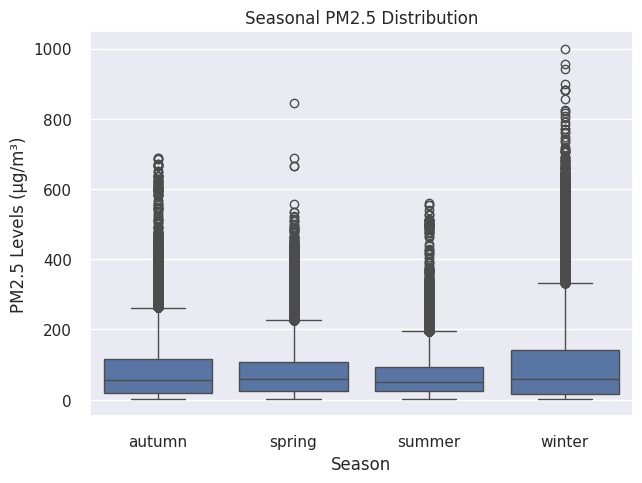

In [11]:
plt.figure(figsize=(7, 5)) # Set figure size
sns.boxplot(data=df, x='season', y='pm25') # Boxplot of PM2.5 by season
plt.title("Seasonal PM2.5 Distribution") # Title
plt.xlabel("Season") # X-axis label
plt.ylabel("PM2.5 Levels (µg/m³)") # Y-axis label
plt.savefig(FIGURES_PATH / "seasonal_pm25_boxplot.png") # Save plot
plt.show() # Show plot

#### Observations
- Winter has the highest medians and widest spread of PM2.5.
- Summer has the lowest, most compact distribution.
- Spring and autumn show moderate levels between the two extremes.

#### Justification
Boxplots summarise group differences visually and highlight distribution patterns (median, IQR, outliers), providing immediate evidence of seasonal separation.

### Monthly distribution (violin plot)

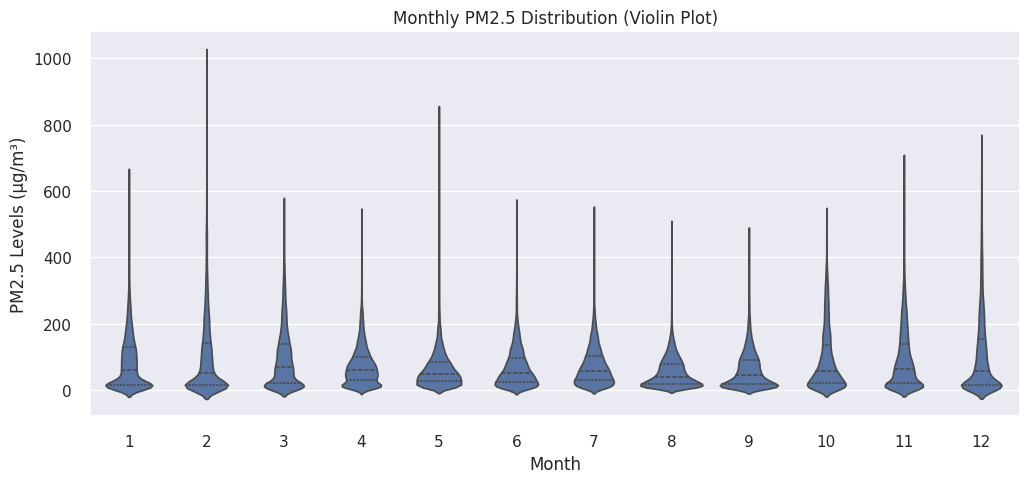

In [12]:
plt.figure(figsize=(12, 5)) # Set figure size
sns.violinplot(data=df, x='month', y='pm25', inner='quartile') # Violin plot of PM2.5 by month
plt.title("Monthly PM2.5 Distribution (Violin Plot)") # Title
plt.xlabel("Month") # X-axis label
plt.ylabel("PM2.5 Levels (µg/m³)") # Y-axis label
plt.savefig(FIGURES_PATH / "monthly_pm25_violinplot.png") # Save plot
plt.show() # Show plot

#### Observations
- Winter months show wide, skewed distributions with many high-PM2.5 events.
- Summer months show narrow, low-level distributions.
- Spring and autumn show intermediate shapes.

#### Justification

Violin plots reveal density and distribution shape, showing how PM2.5 transitions month-to-month and reinforcing the presence of a repeating seasonal cycle.

### Identify high-pollution months/seasons

In [13]:
high_month = monthly_stats['mean'].idxmax() # Month with highest average PM2.5
low_month = monthly_stats['mean'].idxmin() # Month with lowest average PM2.5

high_season = seasonal_stats['mean'].idxmax() # Season with highest average PM2.5
low_season = seasonal_stats['mean'].idxmin() # Season with lowest average PM2.5

print("Highest pollution month:", high_month) # Print highest pollution month
print("Lowest pollution month:", low_month) # Print lowest pollution month
print("Highest pollution season:", high_season) # Print highest pollution season
print("Lowest pollution season:", low_season) # Print lowest pollution season

Highest pollution month: 12
Lowest pollution month: 8
Highest pollution season: winter
Lowest pollution season: summer


#### Observations

- December (winter) is the most polluted month.
- August (summer) is the cleanest.
- Seasonal ranking: Winter > Autumn > Spring > Summer.

#### Justification

Identifying extremes provides a simple, intuitive confirmation of seasonal patterns and aligns with known heating/dispersion cycles.

## Year-on-Year Comparison

### PM2.5 monthly trends per year

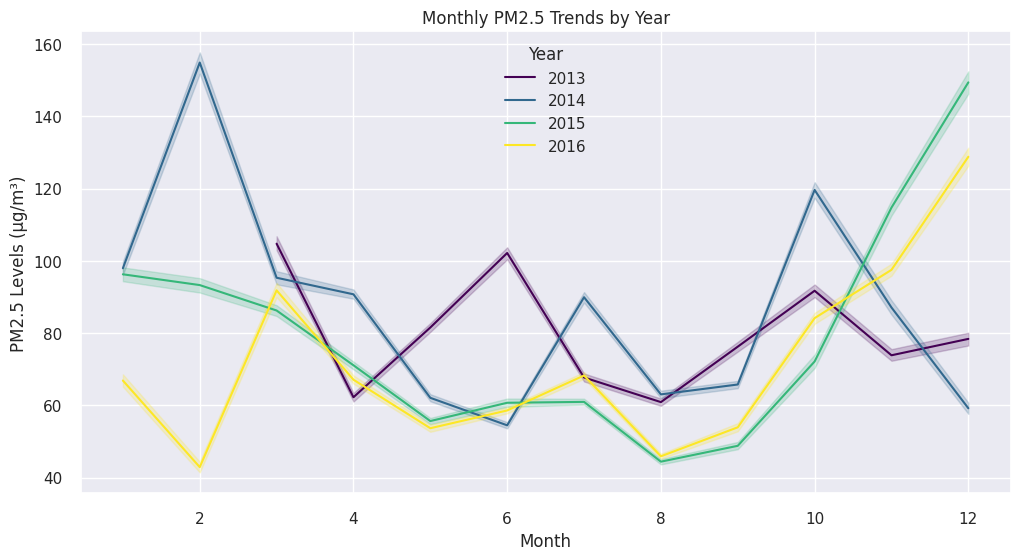

In [14]:
plt.figure(figsize=(12, 6)) # Set figure size
sns.lineplot(
    data=df,
    x='month',
    y='pm25',
    hue='year',
    palette='viridis'
) # Line plot of monthly PM2.5 trends by year
plt.title("Monthly PM2.5 Trends by Year") # Title
plt.xlabel("Month") # X-axis label
plt.ylabel("PM2.5 Levels (µg/m³)") # Y-axis label
plt.legend(title='Year') # Legend
plt.savefig(FIGURES_PATH / "monthly_pm25_trends.png") # Save plot
plt.show() # Show plot

#### Observations
- Every year follows the same pattern: winter peaks → spring decline → summer lows → autumn rise.
- Year-to-year differences exist in magnitude, but the shape is stable.

#### Justification

Confirms that seasonality is not a one-year anomaly but a persistent multi-year feature.

### Seasonality change over years

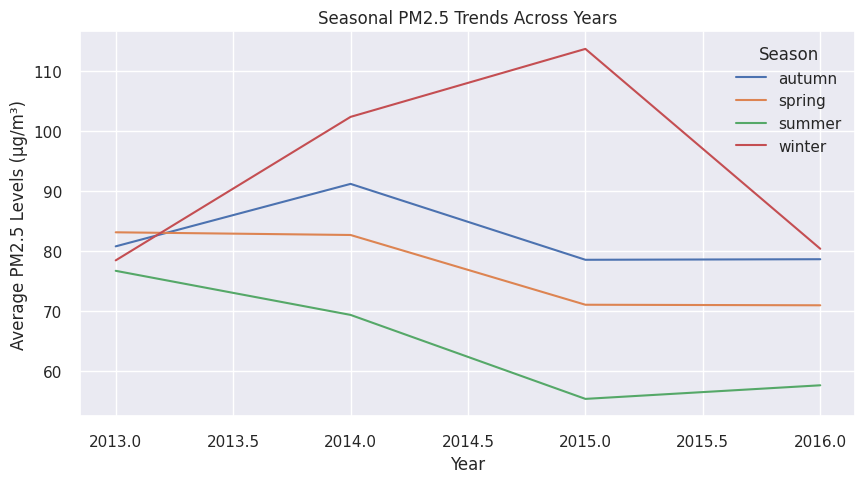

In [15]:
seasonal_yearly = df.groupby(['year', 'season'], observed=False)['pm25'].mean().reset_index() # Calculate seasonal averages per year

plt.figure(figsize=(10, 5)) # Set figure size
sns.lineplot(
    data=seasonal_yearly,
    x='year',
    y='pm25',
    hue='season'
) # Plot seasonal trends across years
plt.title("Seasonal PM2.5 Trends Across Years") # Add title
plt.xlabel("Year") # X-axis label
plt.ylabel("Average PM2.5 Levels (µg/m³)") # Y-axis label
plt.legend(title='Season') # Legend
plt.savefig(FIGURES_PATH / "seasonal_pm25_trends.png") # Save plot   
plt.show() # Show plot

#### Observations

- Winter consistently has the highest seasonal averages; summer the lowest.
- Seasonal lines do not cross often, reinforcing stable ordering.

#### Justification

Aggregating by season smooths noise and highlights the long-term consistency of the seasonal cycle.

### Check if seasonal pattern weakens or strengthens

In [16]:
seasonal_variability = seasonal_yearly.groupby('season', observed=False)['pm25'].var()  # Calculate variance of PM2.5 for each season
seasonal_variability  # Display seasonal variability

season
autumn     36.318945
spring     47.211838
summer    101.054858
winter    295.015094
Name: pm25, dtype: float64

#### Observations

- Winter has the highest variance, showing unstable pollution conditions.
- Summer variance is moderate; spring and autumn are more stable.

#### Justification

Variance helps reveal not just mean differences but stability/instability of pollution within seasons, supporting seasonal interpretation.

## Weather Variable Relationships

### Temperature vs PM2.5 by season

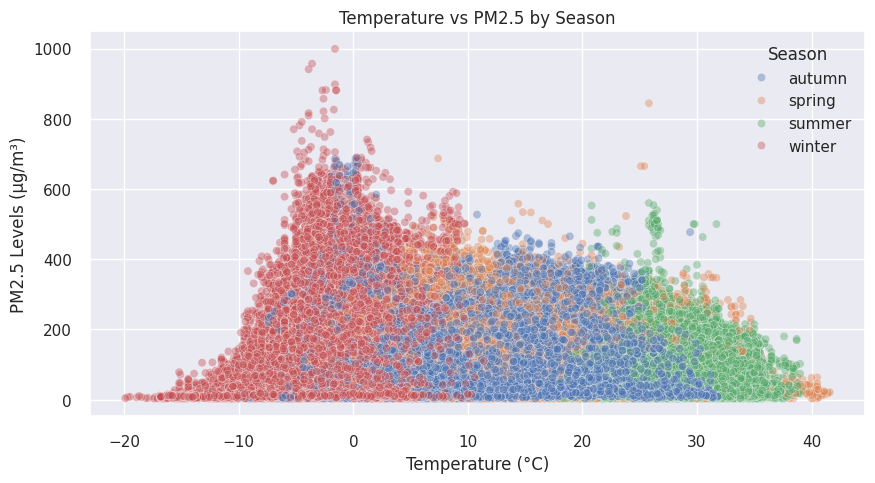

In [17]:
plt.figure(figsize=(10, 5)) # Set figure size
sns.scatterplot(
    data=df,
    x='temperature',
    y='pm25',
    hue='season',
    alpha=0.4
) # Scatter plot of Temperature vs PM2.5 colored by season 
plt.title("Temperature vs PM2.5 by Season") # Add title
plt.xlabel("Temperature (°C)") # X-axis label
plt.ylabel("PM2.5 Levels (µg/m³)") # Y-axis label
plt.legend(title='Season') # Legend
plt.savefig(FIGURES_PATH / "temp_vs_pm25_season.png") # Save plot
plt.show() # Show plot

#### Observations

- Strong negative relationship: colder conditions correspond to higher PM2.5.
- Winter shows the strongest clustering of low temp / high pollution.

#### Justification

Temperature affects mixing height and dispersion; this plot links meteorological conditions to seasonal pollution trends.

### Pressure vs PM2.5 by season

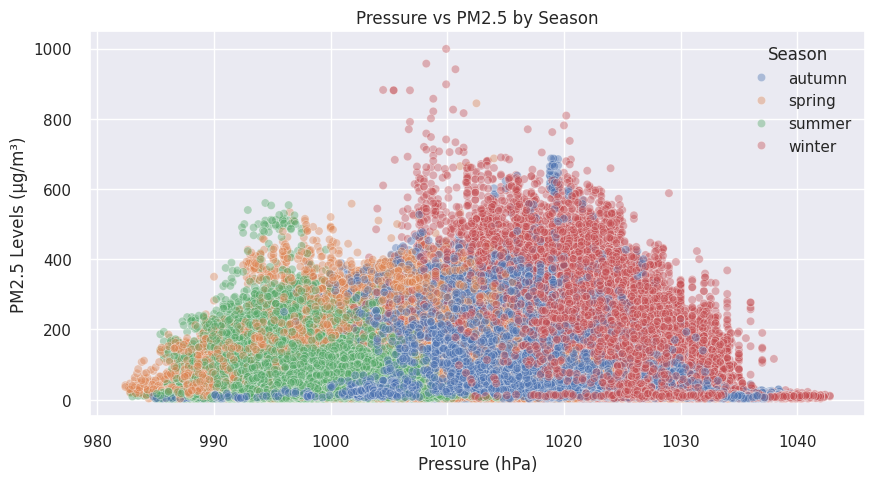

In [18]:
plt.figure(figsize=(10, 5)) # Set figure size
sns.scatterplot(
    data=df,
    x='pressure',
    y='pm25',
    hue='season',
    alpha=0.4
) # Scatter plot of Pressure vs PM2.5 colored by season
plt.title("Pressure vs PM2.5 by Season") # Add title
plt.xlabel("Pressure (hPa)") # X-axis label
plt.ylabel("PM2.5 Levels (µg/m³)") # Y-axis label
plt.legend(title='Season') # Legend
plt.savefig(FIGURES_PATH / "pressure_vs_pm25_season.png") # Save plot
plt.show() # Show plot

#### Observations

- Higher pressure generally corresponds to higher PM2.5.
- Winter has the strongest high-pressure haze episodes.

#### Justification

High-pressure systems create stagnant air; this plot explains why winter pollution persists.

### Dew Point vs PM2.5 by season

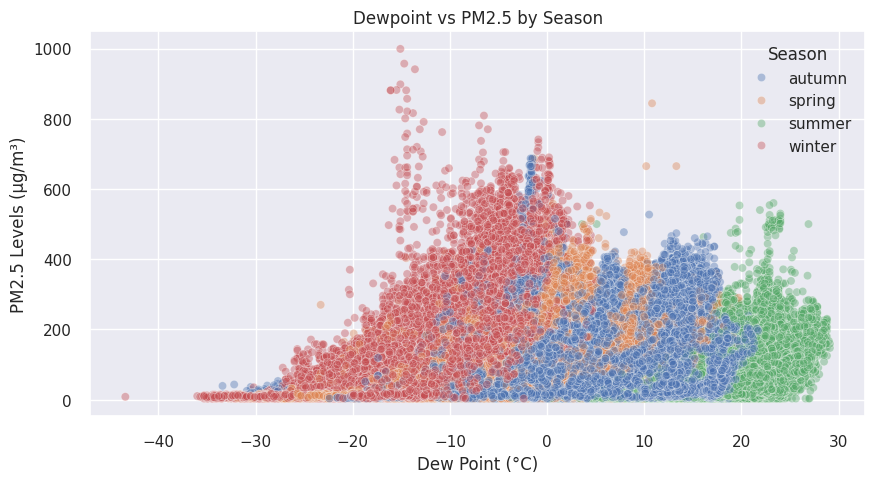

In [19]:
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df,
    x='dew_point',
    y='pm25',
    hue='season',
    alpha=0.4
) # Scatter plot of Dewpoint vs PM2.5 colored by season
plt.title("Dewpoint vs PM2.5 by Season") # Add title
plt.xlabel("Dew Point (°C)") # X-axis label
plt.ylabel("PM2.5 Levels (µg/m³)") # Y-axis label
plt.legend(title='Season') # Legend
plt.savefig(FIGURES_PATH / "dewpoint_vs_pm25_season.png") # Save
plt.show() # Show plot

#### Observations

- Higher dewpoint relates to higher PM2.5 in winter.
- Summer remains clean despite high humidity.

#### Justification

Humidity affects secondary aerosol formation, helping explain winter haze behaviour.

### Correlate weather patterns with pollution cycles

In [20]:
weather_corr = df[['pm25', 'temperature', 'pressure', 'dew_point', 'relative_humidity']].corr()  # Calculate correlation matrix for PM2.5 and weather variables
weather_corr  # Display correlation matrix

,pm25,temperature,pressure,dew_point,relative_humidity
pm25,1.000000,-0.130435,0.022299,0.114977,0.372720
temperature,-0.130435,1.000000,-0.807499,0.815062,0.091239
pressure,0.022299,-0.807499,1.000000,-0.741567,-0.219712
dew_point,0.114977,0.815062,-0.741567,1.000000,0.632970
relative_humidity,0.372720,0.091239,-0.219712,0.632970,1.000000


#### Observations

- PM2.5 negatively correlates with temperature.
- Positive correlation with pressure and dewpoint.

#### Justification

Quantifies meteorological influences and supports including these variables in seasonal interpretation.



## Statistical Validation

### ANOVA: PM2.5 ~ season

In [21]:
anova_season = pg.anova(
    dv='pm25',
    between='season',
    data=df,
    detailed=True
)  # Perform ANOVA to test for differences in PM2.5 across seasons
anova_season  # Display ANOVA results

,Source,SS,DF,MS,F,p-unc,np2
0,season,5.014665e+07,3,1.671555e+07,2703.69741,0.0,0.019693
1,Within,2.496311e+09,403772,6.182478e+03,NaN,NaN,NaN


#### Observations

- ANOVA shows a highly significant effect of season (p < 0.001).
- Between-season variation is much larger than within-season variation.

#### Justification

ANOVA is appropriate for comparing means across 4 independent groups and formally confirms significant seasonal differences.

### Tukey HSD

In [22]:
tukey_season = pg.pairwise_tukey(
    dv='pm25',
    between='season',
    data=df
) # Perform Tukey's HSD post-hoc test
tukey_season # Display Tukey's test results

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,autumn,spring,82.213860,76.876634,5.337226,0.342504,15.582948,0.0,0.070837
1,autumn,summer,82.213860,64.683853,17.530007,0.342504,51.181866,0.0,0.255669
2,autumn,winter,82.213860,96.587229,-14.373368,0.360635,-39.855712,0.0,-0.152488
3,spring,summer,76.876634,64.683853,12.192781,0.341567,35.696583,0.0,0.199444
4,spring,winter,76.876634,96.587229,-19.710594,0.359745,-54.790424,0.0,-0.223165
5,summer,winter,64.683853,96.587229,-31.903375,0.359745,-88.683245,0.0,-0.388749


#### Observations

- All seasonal pairs differ significantly.
- Confirms hierarchy: Winter > Autumn > Spring > Summer.

#### Justification

Tukey identifies which seasons differ while controlling for multiple comparisons, supporting interpretation of seasonal structure.

### Seasonal decomposition

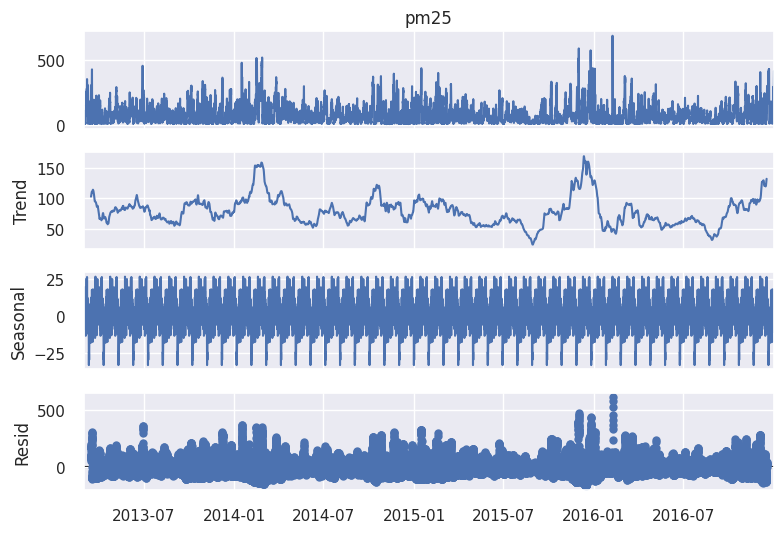

In [23]:
df['datetime'] = pd.to_datetime(df['datetime']) # Ensure datetime is in datetime format

df_avg = (
    df.groupby('datetime', observed=False)['pm25']
      .mean()
      .sort_index()
) # Average PM2.5 by datetime

ts = df_avg.asfreq('h') # Set frequency to hourly
ts = ts.interpolate(method='time') # Interpolate missing values

decomposition = seasonal_decompose(ts, model='additive', period=24*30) # Monthly seasonality 
decomposition.plot() # Plot the decomposition
plt.savefig(FIGURES_PATH / "seasonal_decompose_pm25.png") # Save plot
plt.show() # Display the plot

#### Observations

- Seasonal component shows consistent winter peaks and summer lows every year.
- Trend indicates gradual long-term improvement, but seasonality persists.

#### Justification

Decomposition mathematically confirms the presence and stability of an annual seasonal cycle.

## Summary – Hypothesis H1: Seasonal Patterns in PM2.5

The analysis shows strong and consistent evidence that PM2.5 in Beijing follows a clear seasonal cycle.  
Winter exhibits the highest and most variable PM2.5 levels, driven by heating emissions and stagnant atmospheric conditions.  
Summer shows the lowest levels due to rainfall, mixing, and monsoon winds. Spring and autumn occupy predictable transitional positions.

Statistical testing supports these observations:
- **ANOVA** confirms significant differences in PM2.5 between seasons.  
- **Tukey HSD** shows all seasonal pairs differ significantly.  
- **Seasonal decomposition** identifies a stable annual cycle repeated across years.

Meteorological variables (temperature, pressure, dewpoint) provide environmental justification for these seasonal patterns.

### Conclusion  
**H1 is strongly supported.** PM2.5 displays a robust, recurring seasonal pattern shaped by atmospheric and human activity cycles.

---
### AI Assistance Note
Some narrative text and minor formatting or wording improvements in this notebook were supported by AI-assisted tools (ChatGPT for documentation clarity, Copilot for small routine code suggestions, and Grammarly for proofreading). All analysis, code logic, feature engineering, modelling, and interpretations were independently created by the author.